# Convolutional autoencoder
* Uses stack of convolutional layers instead of Denses.
* Convolutional layers exhibit a spatial bias, i.e. each output neuron maps from a particular region of the input image.
* Convolutional layers add *breadth* to a layer by generating **several** feature maps which are simultaneously accessed by the next layer.

In [1]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf
from skimage import draw
import dataset

In [2]:
expl_idx = 0
vmin, vmax = -128, 128
nrows, ncols = 64, 64
nsamples = 10_000
nepochs = 50
ncomponents = 3
batch_size = 32 

### 1. Generate data

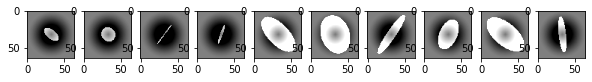

In [3]:
data = dataset.construct(nsamples, nrows, ncols, "ellipse")
X = data - data.mean(axis=0) # center data: same input data as PCA.
X = K.reshape(X, (-1, nrows, ncols, 1))

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(tf.reshape(X[i], (nrows, ncols)), vmin=vmin, vmax=vmax)

### 2. Create model
* Use Dense layers before and after bottleneck to allow varying latent space wo/ changing output shape.
* Convolutional layers with one filter are equivalent to a Dense layer using only a small subset of its weights which map to one particular and unique region of the input image. The magnitude of these weights is equal for all neurons.
* Adding filters to a convolutional layer add **breadth** to the network. This makes them a little bit different (and more powerful) than a single Dense layer.
* The amount of parameters for convolutional layers are usually much less than for Dense layers.

In [4]:
encoder = keras.Sequential([
        keras.layers.Input(shape=(nrows,ncols,1)),
        keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Flatten(),
        keras.layers.Dense(units=ncomponents, activation='linear', use_bias=False),
    ])

decoder = keras.Sequential([
        keras.layers.Input(shape=(ncomponents,)),
        keras.layers.Dense(units=nrows//4*ncols//4*16, activation='sigmoid', use_bias=False), # add units to avoid bottleneck forming here.
        keras.layers.Reshape(target_shape=(nrows//4,ncols//4,16)),      # .. reshape those units into channel dimension.
        keras.layers.Conv2DTranspose(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding='same', activation='linear', use_bias=False),
    ])

cae = keras.Sequential([encoder, decoder])
cae.compile(loss='mse', optimizer='adam')

### 3. Train model
* Training seems to converge much faster than DAE.

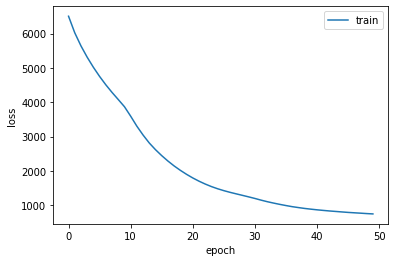

In [5]:
history = cae.fit(X, X, epochs=nepochs, batch_size=batch_size, verbose=0)
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

### 4. Transform into and from latent space

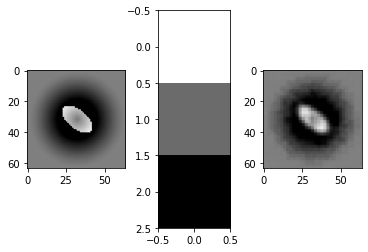

In [6]:
Z = encoder(X) # only subset; full data is too big for my GPU memory.
X_pred = decoder(Z)

fig, ax = plt.subplots(ncols=3, nrows=1)
ax[0].imshow(tf.reshape(X[expl_idx],(nrows, ncols)), vmin=vmin, vmax=vmax)
ax[1].imshow(tf.reshape(Z[expl_idx], (-1, 1)))
ax[2].imshow(tf.reshape(X_pred[expl_idx], (nrows, ncols)), vmin=vmin, vmax=vmax)

### 5. Interpolation in latent space

In [7]:
from ipywidgets import interactive
import ipywidgets as widgets

def f(**kwargs):
    z = np.array(list(kwargs.values()), dtype='float32')
    x_pred = decoder(z.reshape(1,-1))
    plt.figure(2)
    plt.imshow(tf.reshape(x_pred,(nrows, ncols)), vmin=vmin, vmax=vmax)

scores = Z[expl_idx]

sliders = {f"PC{i+1}": widgets.FloatSlider(min=tf.reduce_min(z),max=tf.reduce_max(z),value=score) 
           for (i,score), z in zip(enumerate(scores), tf.transpose(Z))}

interactive(f, **sliders)
ix_plot = interactive(f, **sliders)
output = ix_plot.children[-1]
output.layout.height = '250px'
ix_plot

interactive(children=(FloatSlider(value=33.664794921875, description='PC1', max=274.1339111328125, min=-4.7690…

The found latent axes seem correlated - rotation and size seem to be mixed.

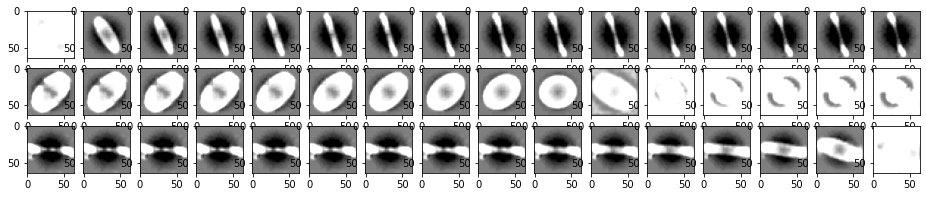

In [8]:
steps = 16
z_vars = [np.linspace(np.min(ax), np.max(ax), steps) for ax in tf.transpose(Z)] # interpolation range
fig, axs = plt.subplots(ncols=steps, nrows=ncomponents, figsize=(steps, ncomponents))

for i in range(ncomponents):
    for j in range(steps):
        z = np.zeros_like(Z[expl_idx])
        z[i] = z_vars[i][j]
        x_pred = decoder.predict(z.reshape(1, -1))
        ax = list(axs.flat)[j+i*j] if ncomponents==1 else axs[i, j]
        ax.imshow(tf.reshape(x_pred, (nrows, ncols)), vmin=vmin, vmax=vmax)

### 6. Properties of CAE
* Although there is still correlation between the latent activations, CAE is doing a pretty good job minimizing those by itself, without any regularization.

Cov of latent activations:
 tf.Tensor(
[[ 43.85749    -4.374737  -20.534622 ]
 [ -4.374737    6.399016    3.3365138]
 [-20.534622    3.3365138  19.324741 ]], shape=(3, 3), dtype=float32)


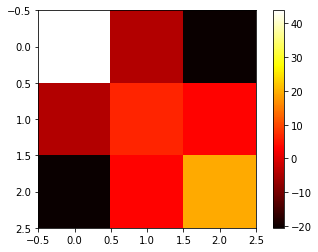

In [9]:
fig, ax = plt.subplots()
Z = tf.subtract(Z, tf.reduce_mean(Z, axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples-1)
print("Cov of latent activations:\n", Z_cov)
plt.imshow(Z_cov, cmap='hot')
plt.colorbar();

### 7. Calculate MSE

In [10]:
X_pred = cae.predict(X)
print("MSE: ", np.square(np.subtract(X, X_pred)).mean())

MSE:  740.7189
